# Homework 2
### I. Intialize constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# number of samples
I = 600

# number of dimensions
N = 2 

# number of clusters
J = 2 

# generate centroides
C = np.array([[0., -0.7], [3.5, .7]])

# pi
π = np.pi

print("Constant values :")
print("- I : " + str(I))
print("- N : " + str(N))
print("- J : " + str(J))

Constant values :
- I : 600
- N : 2
- J : 2


### II. Initialize parameters

In [3]:
### init ϴ => Initialize Φ, µ and Σ
def param_init(display) :
    
    # Φ
    Φ = []
    for j in range(J):
        Φ.append(1/J)

    # µ
    µ = np.random.rand(N,J) + np.array([10,10])
    
    # Σ
    #Σ = np.array([np.diag(np.random.rand(N)), np.diag(np.random.rand(N))])
    Σ = np.array([np.diag([25,25]), np.diag([25, 25])])
    
    if display :
        print("\t============ PARAMETER VALUES ============")
        print("- Φ : ")
        print(Φ)
        print("\n- µ : ")
        print(µ)
        print("\n- Σ : ")
        print(Σ)
            
    return Φ, µ, Σ

### III. Create data set

In [4]:
def get_X(display, µ):
    global I
    if I%2 == 1 :
        I += 1
        
    # generate spherical data centered 
    X = np.zeros((I,N))

    shifted_gaussian = np.random.randn(int(I/2), N) + np.array([20, 20])
    stretched_gaussian = np.dot(np.random.randn(int(I/2), N), C)

    # concatenate the two datasets into the final training set
    X = np.vstack([shifted_gaussian, stretched_gaussian])

    # Visualization
    if display :
        print("\n\tVisualization of X and initial µ")
        plt.scatter(X[:, 0], X[:, 1])
        plt.scatter(µ[0], µ[1])
        plt.show()

    return X

### IV. Calculate E-step

Calcul of Qi(Z=j)

In [5]:
def E_Step(X, Φ, µ, Σ) :
    
    global I
    global J
    global N
    
    W = []
    for i in range(I) :
        Wi = []
        for j in range(J) :
            num1 = 1 / ((2*π)**(N/2) * np.linalg.det(Σ[j])**(1/2))
            Δ = []
            for n in range(N) :
                Δ.append(X[i][n] - µ[j][n])
            num2 = np.exp(-(1/2) * (np.transpose(X[i]-µ[j]).dot(np.linalg.inv(Σ[j]))).dot(X[i]-µ[j]))*Φ[j]
            num3 = np.exp(-(1/2) * (np.transpose(np.array(Δ)).dot(np.linalg.inv(Σ[j]))).dot(np.array(Δ)))*Φ[j]
            num = num1 * num2
            
            denom = 0
            for k in range(J):
                denom1 = 1 / ((2*π)**(N/2) * np.linalg.det(Σ[k])**(1/2))
                denom2 = np.exp(-(1/2) * (np.transpose(X[i]-µ[k]).dot(np.linalg.inv(Σ[k]))).dot(X[i]-µ[k]))*Φ[k]
                denom += denom1 * denom2

            Wi.append(num / denom)  
        W.append(Wi)
        
    return np.array(W)

### V. Calculate M-step

Update parameters Φ, µ and Σ.

In [6]:
def updateΦ(X, W) :
    
    global I
    global J
    global N
    
    Φ = []
    for j in range(J) :
        numΦ = sum([w[j] for w in W])
        Φ.append(numΦ / I)
        
    return Φ


def updateµ(X, W) :
    
    global I
    global J
    global N
    
    µ = []
    for j in range(J) :
        numµ = 0
        denomµ = sum([w[j] for w in W])

        for i in range(I):
            numµ += W[i][j] * X[i]
            
        µ.append(numµ / denomµ)
        
    return np.array(µ)


def updateΣ(X, W, µ) :
    
    global I
    global J
    global N
    
    Σ = []
    for j in range(J) :
        denomΣ = sum([w[j] for w in W])
        numΣ = np.zeros((N,N))

        for i in range (I) :
            numΣ += W[i][j]*np.transpose([X[i]-µ[j]]).dot(np.array([X[i]-µ[j]]))
            
        Σ.append(numΣ / denomΣ)

    return np.array(Σ)

### VI. Calculate the lielihood of each point

In [11]:
def GMM(display = True) :

    Φ, µ, Σ = param_init(display)
    
    if display :
        print("\n\t============ START ITERATIONS ============\n")
        print("\t - iteration = 1")
        
    X = get_X(display, µ)
    
    old_µ = µ
        
    iteration = 2
    
    # iterate until convergence :
    while iteration < 100 :
        
        # E-step :
        W = E_Step(X, Φ, µ, Σ)
        
        # M-step :
        old_µ = µ
        Φ = updateΦ(X, W)
        µ = updateµ(X, W)
        Σ = updateΣ(X, W, µ)
        
        break_condition = 0
        for n in range(N):
            for j in range(J):
                if (old_µ[j][n] - µ[j][n])**2 < 10**(-10) :
                    break_condition += 1
                    
        if break_condition == int(N*J) :
            break
            
        elif display :
            print("\n\t - iteration = " + str(iteration))
            plt.scatter(X[:, 0], X[:, 1])
            plt.scatter(µ[:, 0], µ[:, 1])
            plt.show()
        
        iteration += 1
    
    return X, np.array(W), Φ, µ, Σ, iteration

### VII. Get the predicted cluster of each point

In [8]:
def get_prediction(W, X) :
    
    global I
    global J
    
    Z = np.array([0 for i in range(I)])

    for i in range(I) :
        for j in range(J) :
            if W[i][j] == max(W[i]) :
                Z[i] = j
            
    X_predicted = []
    for j in range(J) :
        Xi = []
        for i in range(I) :
            if Z[i] == j :
                Xi.append(X[i])
                
        X_predicted.append(Xi)
        
    return Z, np.array(X_predicted)

### VII. Print and plot the results

In [9]:
def results(X, W, Φ, µ, Σ, iteration):
    
    global J
    global I
    
    Z, X_predicted = get_prediction(W, X)
    
    print("\t============ RESULTS ============")
    print("\n- Φ : ")
    print(Φ)
    print("\n- µ : ")
    print(µ)  
    print("\n- Σ : ")
    print(Σ)
    print("\n- Iteration number : " + str(iteration))
    
    fig, ax = plt.subplots(J+2, figsize=(8,19))
    color = ['r','y','c','m']
    
    # Graphe 1 : position of means
    ax[0].set_title("Position of µ in each cluster")
    ax[0].scatter(X[:, 0], X[:, 1])
    for j in range(J):
        ax[0].scatter(µ[j][0], µ[j][1], label='µ' + str(j), color = color[j])
    ax[0].legend(loc="upper left")
    
    # Graphe 2 : clustering data
    ax[1].set_title("Clusters of data")
    for j in range(J) :
        ax[1].scatter(X_predicted[j][:, 0], X_predicted[j][:, 1], label='Cluster n°' + str(j))
    ax[1].legend(loc="upper left")
    
    # Graphes : Covariance of all clusters
    for j in range(J):
        ax[j+2].set_title("Zoom on Σ of cluster n°" + str(j))
        ax[j+2].scatter(X_predicted[j][:, 0], X_predicted[j][:, 1])
        ax[j+2].quiver(µ[j][0], µ[j][1], Σ[j][0][0], Σ[j][0][1], color=['m'])
        ax[j+2].quiver(µ[j][0], µ[j][1], Σ[j][1][0], Σ[j][1][1], color=['r'])

    fig.tight_layout()

### VIII. Compute the homework

	============ PARAMETER VALUES ============
- Φ : 
[0.5, 0.5]

- µ : 
[[10.37390805 10.40713791]
 [10.22292493 10.78759036]]

- Σ : 
[[[25  0]
  [ 0 25]]

 [[25  0]
  [ 0 25]]]

	============ START ITERATIONS ============

	 - iteration = 1

	Visualization of X and initial µ


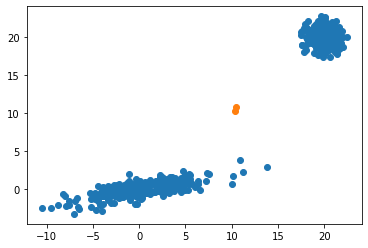


	 - iteration = 2


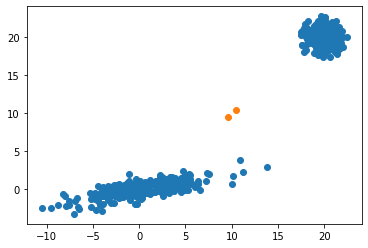


	 - iteration = 3


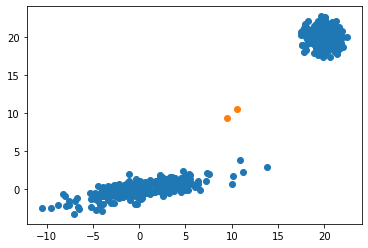


	 - iteration = 4


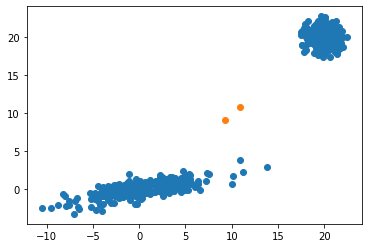


	 - iteration = 5


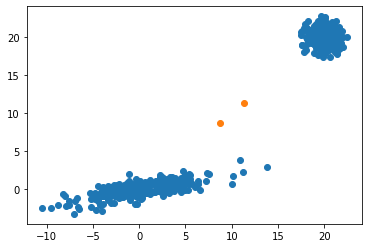


	 - iteration = 6


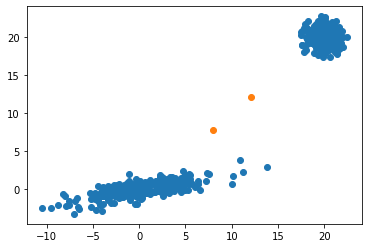


	 - iteration = 7


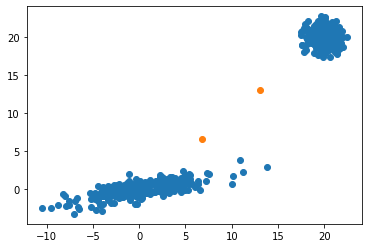

In [ ]:
X, W, Φ, µ, Σ, iteration = GMM()
results(X, W, Φ, µ, Σ, iteration)